In [118]:
import cv2
import torch
import numpy as np
import pathlib
import albumentations as A
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from tqdm.auto import tqdm
from torchinfo import summary
from torchvision import models
from tqdm.notebook import tqdm
from torchvision import transforms as T
from torch.utils.data import DataLoader
from torchvision.datasets import VOCSegmentation

device = "cuda" if torch.cuda.is_available() else "cpu"

In [226]:
VOC_CLASSES = [
    "background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus",
    "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike",
    "person", "potted plant", "sheep", "sofa", "train", "tv/monitor"
]

# Define the VOC_COLORMAP with corrected RGB values
VOC_COLORMAP = [
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
    [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
    [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128],
    [64, 128, 128], [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0],
    [128, 192, 0], [0, 64, 128]
]

class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=False, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index], cv2.IMREAD_GRAYSCALE)
        a = self.transform(image=image, mask=mask)
        return torch.from_numpy(a['image']).permute(2, 0, 1).float(), torch.from_numpy(a['mask']).long()

In [177]:
from PIL import Image
from torchvision.utils import save_image

def convert_to_segmentation_mask(mask):
    height, width = mask.shape[:2]
    segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
    for label_index, label in enumerate(VOC_COLORMAP):
        segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
    return segmentation_mask

mask_paths = list(pathlib.Path("./data/VOCdevkit/VOC2012/SegmentationClass").glob("*.png"))

index = 0

for mask_path in mask_paths:
    mask = cv2.imread(str(mask_path))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask = convert_to_segmentation_mask(mask)
    mask = T.ToTensor()(mask)
    mask = torch.argmax(mask, dim=0)
    mask = mask.to(device, dtype=torch.float32)
    grayscale_image = torch.squeeze(mask).byte().cpu().numpy()
    mask = Image.fromarray(grayscale_image)
    mask.save(str(mask_path))
    index = index + 1

In [166]:
from PIL import Image

mask = cv2.imread("./data/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png")
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
mask = convert_to_segmentation_mask(mask)
mask = T.ToTensor()(mask)
mask = torch.argmax(mask, dim=0)
mask = mask.to(device, dtype=torch.float32)

grayscale_transform = T.Compose([
    T.ToPILImage(),             # Convert to PIL Image
    T.Grayscale(num_output_channels=1),  # Convert to grayscale
])

grayscale_image = torch.squeeze(mask).byte().cpu().numpy()
mask = Image.fromarray(grayscale_image)
mask.save("./data/hey.png")

mask = cv2.imread("./data/VOCdevkit/VOC2012/OneHotSegmentation/202.png", cv2.IMREAD_GRAYSCALE)
np.unique(mask)
mask = torch.from_numpy(mask)
torch.unique(mask)

tensor([ 0,  8, 18], dtype=torch.uint8)

In [73]:
from PIL import Image
mask = Image.open("./data/VOCdevkit/VOC2012/OneHotSegmentation/1.png")
mask = T.ToTensor()(mask)
torch.unique(mask)

tensor([0., 1.])

In [227]:
data_transform = A.Compose([A.Resize(256, 256)])

train_set = PascalVOCSearchDataset(root="./data", image_set="train", transform=data_transform)
val_set = PascalVOCSearchDataset(root="./data", image_set="trainval", transform=data_transform)
test_set = PascalVOCSearchDataset(root="./data", image_set="val")

In [228]:
train_loader = DataLoader(train_set, batch_size=4, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=4, shuffle=True, drop_last=True)

In [223]:
img, mask = train_set[4]
img.dtype

torch.float32

In [122]:
class CustomResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet50(pretrained=True)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        auxiliary_x = self.resnet.layer1(x)
        x = self.resnet.layer2(auxiliary_x)

        return x, auxiliary_x

In [123]:
class PyramidPoolingModule(nn.Module):

    def __init__(self, pools, in_channels, input_shape):
        super().__init__()
        self.input_shape = input_shape
        self.pooling_layers = nn.ModuleList([
            nn.Sequential(
                nn.AdaptiveAvgPool2d(output_size=p), # Pool
                nn.Conv2d(in_channels, int(in_channels / len(pools)), 1, 1, 0, 1, bias=False),
                nn.Dropout2d()
            )
            for p in pools
        ])

    def forward(self, x):
        outputs = [x]
        for pooling_layer in self.pooling_layers:
            layer_output = pooling_layer(x)
            outputs.append(F.interpolate(layer_output, size=self.input_shape, mode="bilinear", align_corners=True))

        return torch.cat(outputs, dim=1)

In [124]:
class SegmentationClassifier(nn.Module):

    def __init__(self, in_channels, out_channels, scale_factor):
        super().__init__()
        self.segmentation = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Dropout2d(),
            nn.UpsamplingBilinear2d(scale_factor=scale_factor)
        )

    def forward(self, x):
        return self.segmentation(x)

In [125]:
class PSPNet(nn.Module):
    def __init__(self, input_shape, n_classes):
        super().__init__()
        self.feature_extractor = CustomResNet()
        self.pyramid_pooling = PyramidPoolingModule(input_shape=(int(input_shape[0] / 8), int(input_shape[1] / 8)), in_channels=512, pools = (6, 3, 2, 1))
        self.classifier = SegmentationClassifier(in_channels=1024, out_channels=n_classes, scale_factor=8)
        self.aux_classifier = SegmentationClassifier(in_channels=256, out_channels=n_classes, scale_factor=4)

    def forward(self, x):
        encoder_outputs, encoder_auxiliary = self.feature_extractor(x)
        pyramid_outputs = self.pyramid_pooling(encoder_outputs)
        return self.classifier(pyramid_outputs), self.aux_classifier(encoder_auxiliary)

In [126]:
model = PSPNet(input_shape=(256,256), n_classes=21)
summary(model, input_size=(3, 3, 256, 256))

C:\Users\ahou\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ahou\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                             Output Shape              Param #
PSPNet                                             [3, 21, 256, 256]         --
├─CustomResNet: 1-1                                [3, 512, 32, 32]          --
│    └─ResNet: 2-1                                 --                        24,112,104
│    │    └─Conv2d: 3-1                            [3, 64, 128, 128]         9,408
│    │    └─BatchNorm2d: 3-2                       [3, 64, 128, 128]         128
│    │    └─ReLU: 3-3                              [3, 64, 128, 128]         --
│    │    └─MaxPool2d: 3-4                         [3, 64, 64, 64]           --
│    │    └─Sequential: 3-5                        [3, 256, 64, 64]          215,808
│    │    └─Sequential: 3-6                        [3, 512, 32, 32]          1,219,584
├─PyramidPoolingModule: 1-2                        [3, 1024, 32, 32]         --
│    └─ModuleList: 2-2                             --                        --
│    │    └

In [127]:
class DeepSupervisionLoss(nn.Module):
    def __init__(self, alpha):
        super().__init__()
        self.alpha = alpha
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, output, aux_output, target):
        loss = self.cross_entropy(output, target)
        aux_loss = self.cross_entropy(aux_output, target)
        return loss + self.alpha * aux_loss

In [206]:
criterion = DeepSupervisionLoss(alpha=0.4)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [129]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer):
    model.to(device)
    train_loss = []
    val_loss = []
    for e in tqdm(range(epochs)):
        model.train()
        epoch_train_loss = []
        for i, (img, mask) in enumerate(train_loader):
            img = img.to(device)
            mask = mask.to(device)
            output, aux_output = model(img)
            loss = criterion(output, aux_output, mask)
            epoch_train_loss.append(loss.cpu().detach().numpy())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        epoch_val_loss = []
        with torch.inference_mode():
            for i, (img, mask) in enumerate(val_loader):
                img = img.to(device)
                mask = mask
                mask = mask.to(device)
                output, aux_output = model(img)
                loss = criterion(output, aux_output, mask)
                epoch_val_loss.append(loss.cpu().detach().numpy())

        train_loss.append(np.mean(epoch_train_loss))
        val_loss.append(np.mean(epoch_val_loss))

        print(f"Epoch {e} | Loss: {np.mean(epoch_train_loss)} | Val Loss: {np.mean(epoch_val_loss)}")

    return train_loss, val_loss

In [229]:
train_loss, val_loss = fit(30, model, train_loader, val_loader, criterion, optimizer)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0 | Loss: 2.876107692718506 | Val Loss: 1.8611785173416138
Epoch 1 | Loss: 2.7137250900268555 | Val Loss: 1.8034924268722534
Epoch 2 | Loss: 2.752220869064331 | Val Loss: 1.965134620666504
Epoch 3 | Loss: 2.7320291996002197 | Val Loss: 2.171635627746582


KeyboardInterrupt: 

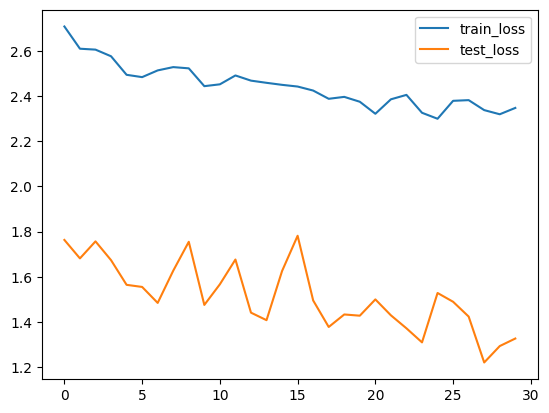

In [19]:
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="test_loss")
plt.legend()

In [20]:
torch.save(model.state_dict(), "./models/01_pspnet_pascalvoc_5.pth")

In [21]:
def predict_image_mask(model, image):
    model.eval()
    model.to(device)
    image = image.to(device)
    with torch.no_grad():
        image = image.unsqueeze(0)
        output, _ = model(image)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked

In [17]:
image, mask = val_set[7]
pred_mask = predict_image_mask(model, image)

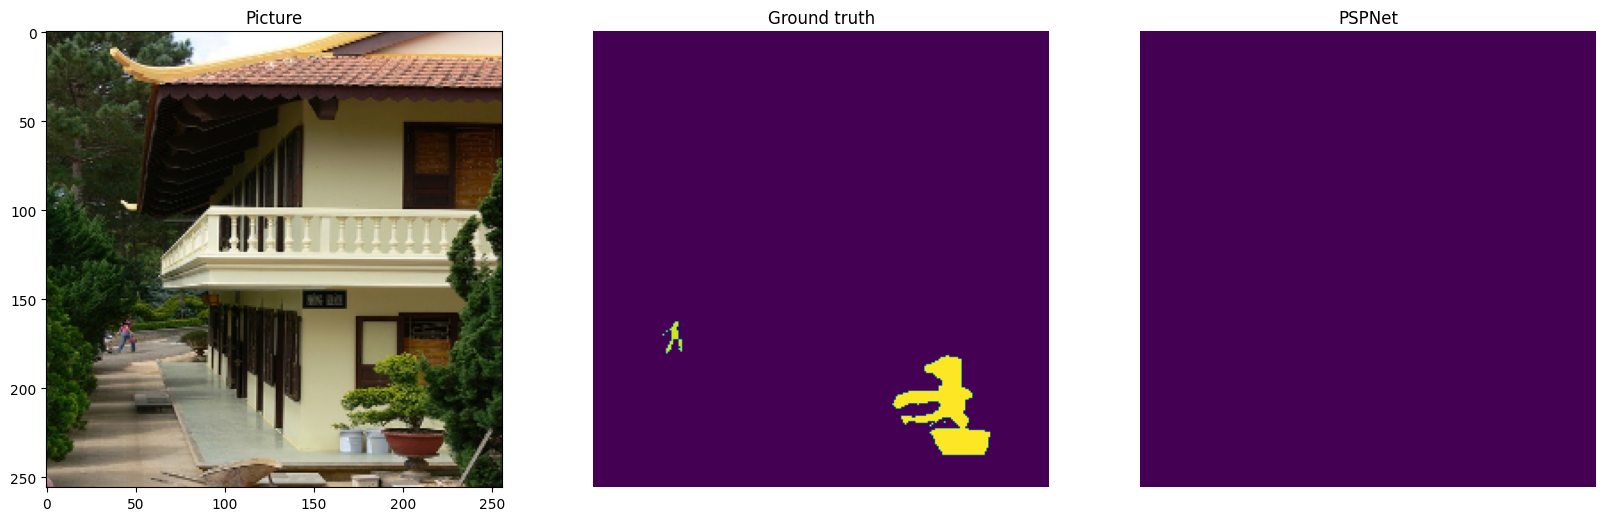

In [43]:
image, mask = val_set[295]
masked = torch.argmax(mask, dim=0)
pred_mask = predict_image_mask(model, image)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(T.ToPILImage()(image))
ax1.set_title('Picture')

ax2.imshow(masked)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('PSPNet')
ax3.set_axis_off()